# HW2 : 이미지 분류 실습 (MLP)

### 이 실습에서는 MLP 기반 이미지 분류기를 직접 설계하고 학습시켜봅니다.
- 다양한 기법을 실험하면서 성능을 비교합니다.
- 자유롭게 모델을 개선하고 최적의 성능을 찾아보세요!
- 아래의 코드는 데이터를 불러오는 예시 코드입니다(수정가능).


> ⚠️ 주의 필독

- `모든 문제에서 validation dataset은 train dataset의 10%로 고정!`
- `Test set 변경 불가능 및 학습 과정에서 모델에 노출되면 0점 처리`
- 최종 제출하는 model parameter로 재구현했을 때, 해당 성능과 근접하게 안나오면 `과제 전체 0점 처리`

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

def get_data_loaders(data_name, batch_size=64, valid_ratio=0.1):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Fashion-MNIST 데이터셋 다운로드 (train, test)
    if data_name == "FashionMNIST":
      full_train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
      test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    elif data_name =="CIFAR10":
      full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
      test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Train/Validation split
    n_total = len(full_train_dataset)
    n_valid = int(n_total * valid_ratio)
    n_train = n_total - n_valid
    train_dataset, valid_dataset = random_split(full_train_dataset, [n_train, n_valid])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Train samples: {n_train}, Validation samples: {n_valid}, Test samples: {len(test_dataset)}")
    return train_loader, valid_loader, test_loader

# DataLoader 실행 예시
train_loader, valid_loader, test_loader = get_data_loaders(data_name="CIFAR10",batch_size=64)
train_loader, valid_loader, test_loader = get_data_loaders(data_name="FashionMNIST",batch_size=64)

100%|██████████| 170M/170M [00:03<00:00, 42.9MB/s]


Train samples: 45000, Validation samples: 5000, Test samples: 10000


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 198kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.71MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.2MB/s]

Train samples: 54000, Validation samples: 6000, Test samples: 10000


# 문제 1 : 데이터 시각화 및 복잡도

- 사용할 데이터셋: `CIFAR-10`, `FashionMNIST` 둘 다 활용합니다.
- Q1. 모든 클래스에 대해 대표 이미지를 1장씩 시각화하시오.
- Q2. 두 데이터셋 중 동일한 layer 수를 갖는 MLP 모델이 분류하기 쉬운 데이터셋을 고르고, 그에 대한 근거를 제시하시오.

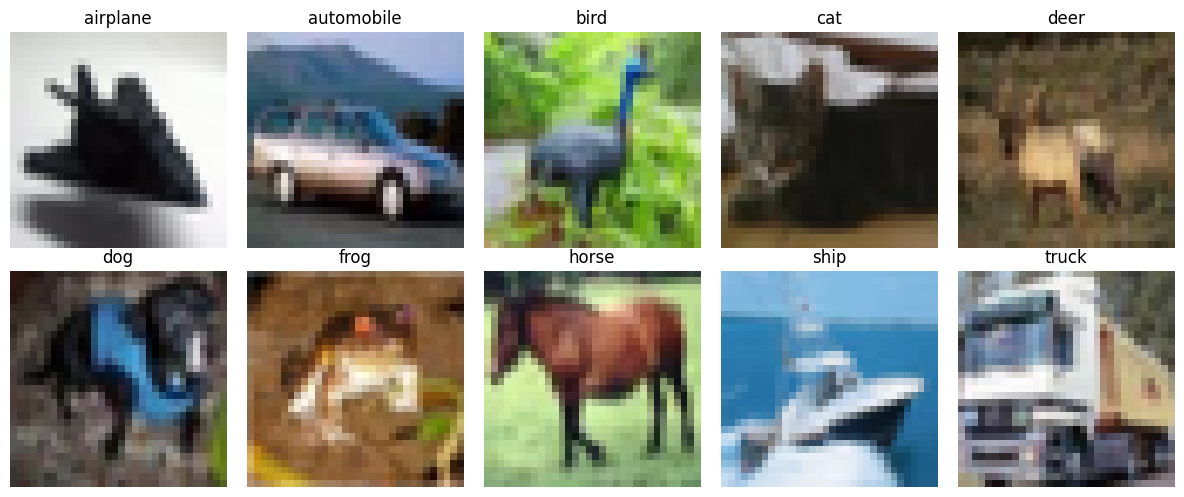

In [ ]:
import matplotlib.pyplot as plt

#plt.subplots(rows, cols, figsize=(cols*2.5, rows*2.5))
# subplots을 사용해서 각 데이터의 이미지들을 한번에 볼 수 있게 시각화해주세요.

# 1. 데이터셋 불러오기
transform = transforms.ToTensor()
dataset_CIFAR10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# 2. 클래스 이름
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

# 3. 클래스별 이미지 하나씩 추출
images = []
labels = []

for class_idx in range(10):
    for img, label in dataset_CIFAR10:
        if label == class_idx:
            images.append(img)
            labels.append(class_names[label])
            break

# 4. 시각화
plt.figure(figsize=(12, 5))
for idx in range(10):
    img = images[idx]
    np_img = img.numpy().transpose((1, 2, 0))  # CHW → HWC

    plt.subplot(2, 5, idx + 1)
    plt.imshow(np_img)
    plt.title(labels[idx])
    plt.axis('off')

plt.tight_layout()
plt.show()

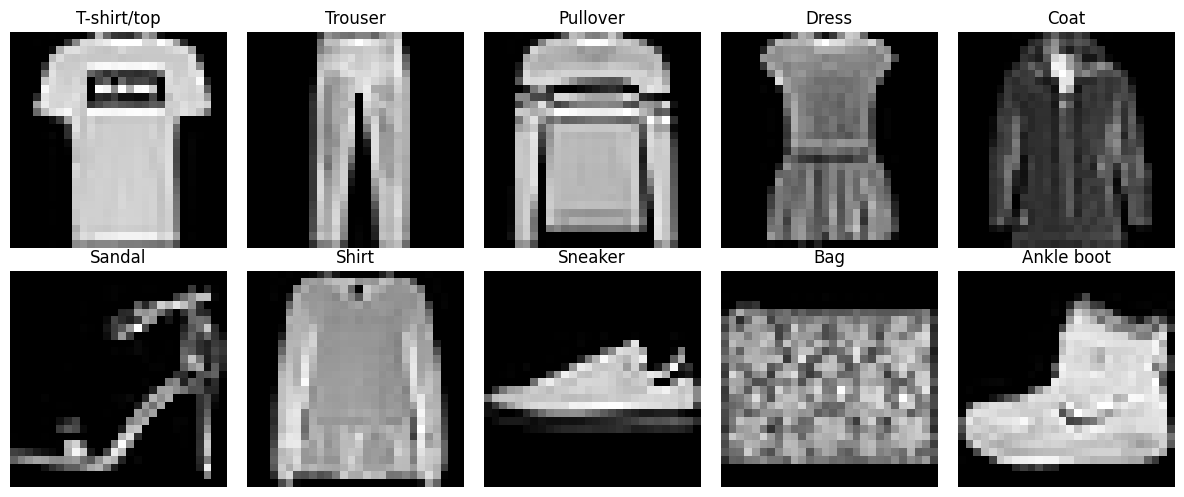

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. FashionMNIST 데이터셋 불러오기
transform = transforms.ToTensor()
dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# 2. 클래스 이름 (공식 제공)
class_names = dataset.classes  # ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                               #  'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 3. 클래스별 이미지 하나씩 추출
images = []
labels = []

for class_idx in range(10):
    for img, label in dataset:
        if label == class_idx:
            images.append(img)
            labels.append(class_names[label])
            break

# 4. 시각화
plt.figure(figsize=(12, 5))
for idx in range(10):
    img = images[idx].squeeze(0).numpy()  # (1, 28, 28) → (28, 28)

    plt.subplot(2, 5, idx + 1)
    plt.imshow(img, cmap='gray')
    plt.title(labels[idx])
    plt.axis('off')

plt.tight_layout()
plt.show()

예시 정답 : FashionMNIST가 CIFAR-10에 비해서 쉬움, 데이터 복잡도가 낮음, CIFAR 10의 경우 배경과 객체를 분리해서 모델이 인식해야 하기 때문에 더 어려움. RGB까지 고려하기 때문에

## 문제 2: Logistic Regression vs MLP + Softmax 비교 실험

이 문제에서는 pytorch를 사용하여 Logistic regression 모델과 MLP 모델을 구성하고, 두 데이터셋을 학습 및 평가합니다.  


- 사용할 데이터셋: `CIFAR-10`, `FashionMNIST` 둘 다 활용합니다.
- **Logistic Regression:** : 1개의 선형 layer + softmax activation 사용
- **MLP:** : 3개의 hidden layer를 사용 (각 hidden layer의 dimension은 100, activation function은 sigmid 함수를 사용합니다.)


<br>
<br>

---

<br>

**모델 구조 및 하이퍼파라미터 조건**

| 모델                | 구성 요소                                            | Epochs | Batch size | Learning rate | Optimizer |
|---------------------|------------------------------------------------------|--------|------------|---------------|-----------|
| Logistic Regression | 1개의 선형 레이어                                    | 10     | 128        | 0.01          | SGD       |
| MLP                 | 3개의 hidden layer (dimension size 100, 활성함수: sigmoid)        | 10     | 128        | 0.01          | SGD       |

> ⚠️ 주의: 설정을 따르지 않을 경우 문제 0점 처리.


<br>

---

<br>

## 보고서 작성 내용

두 데이터셋에 대해서 Logistic Regression 모델과 MLP 모델의 train valdation에 대한 learning curve를 그리고, 분석하시오.


예시 정답 : 충분히 학습하지 못함. underfitting 됐다. 충분히 학습할 여력이 존재한다.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten
        out = self.linear(x)
        return out

class MLPModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.output = nn.Linear(100, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        out = self.output(x)
        return out

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_epoch(model, dataloader, optimizer, device, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    accuracy = correct / total
    return train_loss, accuracy

def evaluate(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    eval_loss = running_loss / total
    accuracy = correct / total
    return eval_loss, accuracy

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LogisticRegressionModel(input_dim=784, num_classes=10).to(device) # FashionMNIST = 28*28*1
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
num_epochs = 10
criterion = nn.CrossEntropyLoss()

print(f"FashionMNIST, LogisticRegression Model Train ...")
train_loader, val_loader, test_loader = get_data_loaders("FashionMNIST", 128)

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, criterion)
    val_loss, val_acc = evaluate(model, val_loader, device)

     # 기록 저장
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

# 모델 별로 test 평가 수행
# (여기서는 단순히 현재 학습된 파라미터로 평가)
val_loss, test_acc = evaluate(model, test_loader, device)
print(f"Test Loss {val_loss:.4f}, Test Acc {test_acc:.4f}")

FashionMNIST, LogisticRegression Model Train ...
Train samples: 54000, Validation samples: 6000, Test samples: 10000
Epoch 1: Train Loss 1.1806, Train Acc 0.6600 | Val Loss 0.8728, Val Acc 0.7325
Epoch 2: Train Loss 0.7933, Train Acc 0.7486 | Val Loss 0.7416, Val Acc 0.7702
Epoch 3: Train Loss 0.7054, Train Acc 0.7760 | Val Loss 0.6807, Val Acc 0.7903
Epoch 4: Train Loss 0.6578, Train Acc 0.7902 | Val Loss 0.6427, Val Acc 0.8012
Epoch 5: Train Loss 0.6261, Train Acc 0.7997 | Val Loss 0.6169, Val Acc 0.8100
Epoch 6: Train Loss 0.6032, Train Acc 0.8063 | Val Loss 0.5969, Val Acc 0.8145
Epoch 7: Train Loss 0.5854, Train Acc 0.8113 | Val Loss 0.5809, Val Acc 0.8178
Epoch 8: Train Loss 0.5712, Train Acc 0.8150 | Val Loss 0.5684, Val Acc 0.8198
Epoch 9: Train Loss 0.5593, Train Acc 0.8181 | Val Loss 0.5580, Val Acc 0.8248
Epoch 10: Train Loss 0.5492, Train Acc 0.8211 | Val Loss 0.5486, Val Acc 0.8258
Test Loss 0.5686, Test Acc 0.8110


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPModel(input_dim=784, num_classes=10).to(device) # FashionMNIST = 28*28*1
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
num_epochs = 10
criterion = nn.CrossEntropyLoss()

print(f"FashionMNIST, MLP Model Train ...")
train_loader, val_loader, test_loader = get_data_loaders("FashionMNIST", 128)

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, criterion)
    val_loss, val_acc = evaluate(model, val_loader, device)

     # 기록 저장
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

# 모델 별로 test 평가 수행
# (여기서는 단순히 현재 학습된 파라미터로 평가)
val_loss, test_acc = evaluate(model, test_loader, device)
print(f"Test Loss {val_loss:.4f}, Test Acc {test_acc:.4f}")

FashionMNIST, MLP Model Train ...
Train samples: 54000, Validation samples: 6000, Test samples: 10000
Epoch 1: Train Loss 2.3060, Train Acc 0.1005 | Val Loss 2.3032, Val Acc 0.0930
Epoch 2: Train Loss 2.3029, Train Acc 0.1026 | Val Loss 2.3027, Val Acc 0.0982
Epoch 3: Train Loss 2.3026, Train Acc 0.1013 | Val Loss 2.3038, Val Acc 0.0995
Epoch 4: Train Loss 2.3025, Train Acc 0.1032 | Val Loss 2.3021, Val Acc 0.1007
Epoch 5: Train Loss 2.3024, Train Acc 0.1042 | Val Loss 2.3024, Val Acc 0.0995
Epoch 6: Train Loss 2.3023, Train Acc 0.1051 | Val Loss 2.3021, Val Acc 0.0930
Epoch 7: Train Loss 2.3020, Train Acc 0.1047 | Val Loss 2.3018, Val Acc 0.0995
Epoch 8: Train Loss 2.3019, Train Acc 0.1058 | Val Loss 2.3016, Val Acc 0.1038
Epoch 9: Train Loss 2.3016, Train Acc 0.1096 | Val Loss 2.3013, Val Acc 0.1067
Epoch 10: Train Loss 2.3014, Train Acc 0.1080 | Val Loss 2.3011, Val Acc 0.1995
Test Loss 2.3015, Test Acc 0.1928


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LogisticRegressionModel(input_dim=3072, num_classes=10).to(device) # CIFAR = 32*32*3
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
num_epochs = 10
criterion = nn.CrossEntropyLoss()

print(f"CIFAR-10, LogisticRegression Model Train ...")
train_loader, val_loader, test_loader = get_data_loaders("CIFAR10", 128)

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, criterion)
    val_loss, val_acc = evaluate(model, val_loader, device)

     # 기록 저장
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

val_loss, test_acc = evaluate(model, test_loader, device)
print(f"Test Loss {val_loss:.4f}, Test Acc {test_acc:.4f}")

CIFAR-10, LogisticRegression Model Train ...
Train samples: 45000, Validation samples: 5000, Test samples: 10000
Epoch 1: Train Loss 2.0040, Train Acc 0.2882 | Val Loss 1.9273, Val Acc 0.3120
Epoch 2: Train Loss 1.8731, Train Acc 0.3482 | Val Loss 1.8597, Val Acc 0.3500
Epoch 3: Train Loss 1.8343, Train Acc 0.3632 | Val Loss 1.8670, Val Acc 0.3324
Epoch 4: Train Loss 1.8127, Train Acc 0.3706 | Val Loss 1.8227, Val Acc 0.3678
Epoch 5: Train Loss 1.7968, Train Acc 0.3794 | Val Loss 1.8178, Val Acc 0.3720
Epoch 6: Train Loss 1.7861, Train Acc 0.3800 | Val Loss 1.8037, Val Acc 0.3722
Epoch 7: Train Loss 1.7778, Train Acc 0.3823 | Val Loss 1.8491, Val Acc 0.3460
Epoch 8: Train Loss 1.7706, Train Acc 0.3894 | Val Loss 1.7874, Val Acc 0.3852
Epoch 9: Train Loss 1.7614, Train Acc 0.3913 | Val Loss 1.7916, Val Acc 0.3812
Epoch 10: Train Loss 1.7582, Train Acc 0.3942 | Val Loss 1.7790, Val Acc 0.3860
Test Loss 1.7734, Test Acc 0.3842


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPModel(input_dim=3072, num_classes=10).to(device) # CIFAR = 32*32*3
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
num_epochs = 10
criterion = nn.CrossEntropyLoss()

print(f"CIFAR-10, MLP Model Train ...")
train_loader, val_loader, test_loader = get_data_loaders("CIFAR10", 128)

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, criterion)
    val_loss, val_acc = evaluate(model, val_loader, device)

     # 기록 저장
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

val_loss, test_acc = evaluate(model, test_loader, device)
print(f"Test Loss {val_loss:.4f}, Test Acc {test_acc:.4f}")

CIFAR-10, MLP Model Train ...
Train samples: 45000, Validation samples: 5000, Test samples: 10000
Epoch 1: Train Loss 2.3044, Train Acc 0.0973 | Val Loss 2.3032, Val Acc 0.0998
Epoch 2: Train Loss 2.3031, Train Acc 0.0997 | Val Loss 2.3027, Val Acc 0.0968
Epoch 3: Train Loss 2.3031, Train Acc 0.0998 | Val Loss 2.3029, Val Acc 0.1002
Epoch 4: Train Loss 2.3031, Train Acc 0.1000 | Val Loss 2.3031, Val Acc 0.1034
Epoch 5: Train Loss 2.3030, Train Acc 0.0989 | Val Loss 2.3032, Val Acc 0.0966
Epoch 6: Train Loss 2.3029, Train Acc 0.1024 | Val Loss 2.3027, Val Acc 0.0968
Epoch 7: Train Loss 2.3029, Train Acc 0.0993 | Val Loss 2.3031, Val Acc 0.1012
Epoch 8: Train Loss 2.3029, Train Acc 0.1021 | Val Loss 2.3030, Val Acc 0.1002
Epoch 9: Train Loss 2.3029, Train Acc 0.1025 | Val Loss 2.3024, Val Acc 0.1078
Epoch 10: Train Loss 2.3028, Train Acc 0.1008 | Val Loss 2.3025, Val Acc 0.0998
Test Loss 2.3025, Test Acc 0.1000


결과 시각화

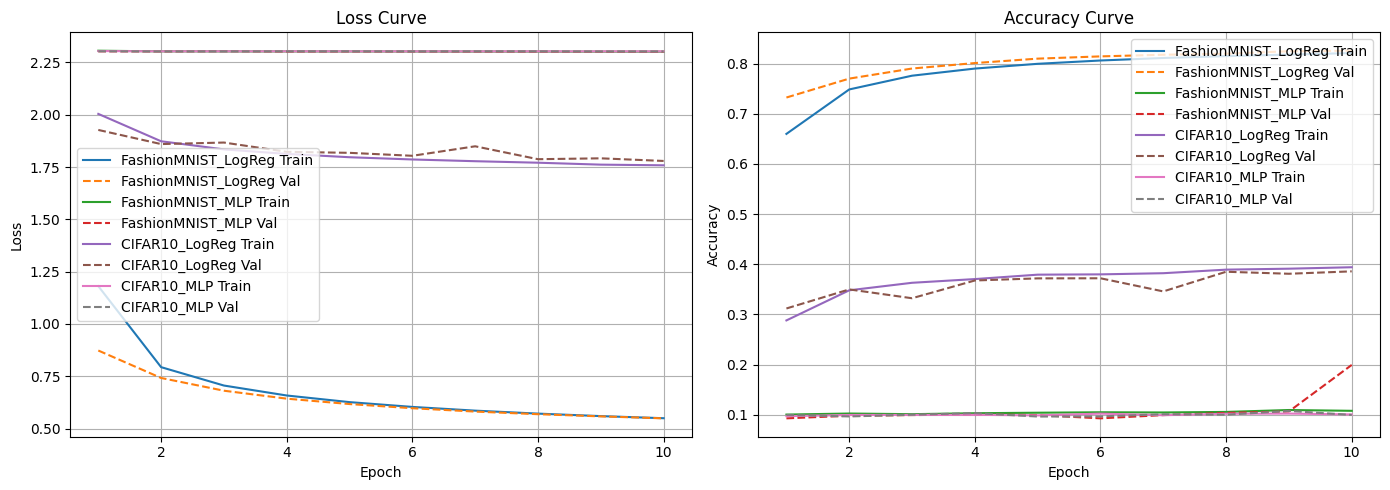

In [ ]:
import matplotlib.pyplot as plt

# 실험 결과
results = {
    "FashionMNIST_LogReg": {
        "train_loss": [1.1806, 0.7933, 0.7054, 0.6578, 0.6261, 0.6032, 0.5854, 0.5712, 0.5593, 0.5492],
        "val_loss":   [0.8728, 0.7416, 0.6807, 0.6427, 0.6169, 0.5969, 0.5809, 0.5684, 0.5580, 0.5486],
        "train_acc":  [0.6600, 0.7486, 0.7760, 0.7902, 0.7997, 0.8063, 0.8113, 0.8150, 0.8181, 0.8211],
        "val_acc":    [0.7325, 0.7702, 0.7903, 0.8012, 0.8100, 0.8145, 0.8178, 0.8198, 0.8248, 0.8258],
    },
    "FashionMNIST_MLP": {
        "train_loss": [2.3060, 2.3029, 2.3026, 2.3025, 2.3024, 2.3023, 2.3020, 2.3019, 2.3016, 2.3014],
        "val_loss":   [2.3032, 2.3027, 2.3038, 2.3021, 2.3024, 2.3021, 2.3018, 2.3016, 2.3013, 2.3011],
        "train_acc":  [0.1005, 0.1026, 0.1013, 0.1032, 0.1042, 0.1051, 0.1047, 0.1058, 0.1096, 0.1080],
        "val_acc":    [0.0930, 0.0982, 0.0995, 0.1007, 0.0995, 0.0930, 0.0995, 0.1038, 0.1067, 0.1995],
    },
    "CIFAR10_LogReg": {
        "train_loss": [2.0040, 1.8731, 1.8343, 1.8127, 1.7968, 1.7861, 1.7778, 1.7706, 1.7614, 1.7582],
        "val_loss":   [1.9273, 1.8597, 1.8670, 1.8227, 1.8178, 1.8037, 1.8491, 1.7874, 1.7916, 1.7790],
        "train_acc":  [0.2882, 0.3482, 0.3632, 0.3706, 0.3794, 0.3800, 0.3823, 0.3894, 0.3913, 0.3942],
        "val_acc":    [0.3120, 0.3500, 0.3324, 0.3678, 0.3720, 0.3722, 0.3460, 0.3852, 0.3812, 0.3860],
    },
    "CIFAR10_MLP": {
        "train_loss": [2.3044, 2.3031, 2.3031, 2.3031, 2.3030, 2.3029, 2.3029, 2.3029, 2.3029, 2.3028],
        "val_loss":   [2.3032, 2.3027, 2.3029, 2.3031, 2.3032, 2.3027, 2.3031, 2.3030, 2.3024, 2.3025],
        "train_acc":  [0.0973, 0.0997, 0.0998, 0.1000, 0.0989, 0.1024, 0.0993, 0.1021, 0.1025, 0.1008],
        "val_acc":    [0.0998, 0.0968, 0.1002, 0.1034, 0.0966, 0.0968, 0.1012, 0.1002, 0.1078, 0.0998],
    }
}

# 시각화
epochs = list(range(1, 11))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss Curve
for label, data in results.items():
    ax1.plot(epochs, data["train_loss"], label=f"{label} Train")
    ax1.plot(epochs, data["val_loss"], linestyle='--', label=f"{label} Val")
ax1.set_title("Loss Curve")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Accuracy Curve
for label, data in results.items():
    ax2.plot(epochs, data["train_acc"], label=f"{label} Train")
    ax2.plot(epochs, data["val_acc"], linestyle='--', label=f"{label} Val")
ax2.set_title("Accuracy Curve")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 문제 3: MLP에 정규화 기법 적용

이번 문제에서는 문제 1에서 만든 MLP 모델에 정규화 기법들을 적용해 봅시다.


<br>

**모델 구조 및 하이퍼파라미터 조건**

| 모델                | 구성 요소                                            | Epochs | Batch size | Learning rate | Optimizer |
|---------------------|------------------------------------------------------|--------|------------|---------------|-----------|
| MLP | 3개의 hidden layer (dimension size 100, 활성함수: sigmoid)                                    | 30     | 128        | 0.01          | SGD       |
| MLP + Regularization                 | 각 layer에 batch norm, dropout 적용, L2 Regularization 적용        | 30     | 128        | 0.01          | SGD       |


> ⚠️ 주의: 설정을 따르지 않을 경우 문제 0점 처리.
<br>

---

<br>

## 보고서 작성 내용

두 데이터셋에 대해서  MLP 모델과 정규화를 추가한 모델의 의 train valdation에 대한 learning curve를 그리고, 분석하시오.

In [ ]:
import torch
import torch.nn as nn

class MLPModel_Reg(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=100, num_classes=10, dropout_prob=0.5):
        super(MLPModel_Reg, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.Sigmoid(),
            nn.Dropout(p=dropout_prob),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.Sigmoid(),
            nn.Dropout(p=dropout_prob),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.Sigmoid(),
            nn.Dropout(p=dropout_prob),

            nn.Linear(hidden_dim, num_classes)  # 출력 레이어에는 softmax 넣지 않음 (CrossEntropyLoss 사용 시)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        return self.model(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPModel_Reg(input_dim=784, num_classes=10).to(device) # FashionMNIST = 28*28*1
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
num_epochs = 30
criterion = nn.CrossEntropyLoss()

print(f"FashionMNIST, MLP Model Reg Train ...")
train_loader, val_loader, test_loader = get_data_loaders("FashionMNIST", 128)

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, criterion)
    val_loss, val_acc = evaluate(model, val_loader, device)
    print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

# 모델 별로 test 평가 수행
# (여기서는 단순히 현재 학습된 파라미터로 평가)
val_loss, test_acc = evaluate(model, test_loader, device)
print(f"Test Loss {val_loss:.4f}, Test Acc {test_acc:.4f}")

FashionMNIST, MLP Model Reg Train ...
Train samples: 54000, Validation samples: 6000, Test samples: 10000
Epoch 1: Train Loss 2.2958, Train Acc 0.1305 | Val Loss 2.1748, Val Acc 0.5360
Epoch 2: Train Loss 2.2103, Train Acc 0.1774 | Val Loss 2.0417, Val Acc 0.4990
Epoch 3: Train Loss 2.0931, Train Acc 0.2206 | Val Loss 1.8728, Val Acc 0.4988
Epoch 4: Train Loss 1.9732, Train Acc 0.2535 | Val Loss 1.7105, Val Acc 0.6008
Epoch 5: Train Loss 1.8619, Train Acc 0.2853 | Val Loss 1.5866, Val Acc 0.5348
Epoch 6: Train Loss 1.7767, Train Acc 0.3083 | Val Loss 1.4856, Val Acc 0.5768
Epoch 7: Train Loss 1.7003, Train Acc 0.3336 | Val Loss 1.4143, Val Acc 0.5730
Epoch 8: Train Loss 1.6454, Train Acc 0.3496 | Val Loss 1.3467, Val Acc 0.5625
Epoch 9: Train Loss 1.5954, Train Acc 0.3678 | Val Loss 1.3046, Val Acc 0.5938
Epoch 10: Train Loss 1.5589, Train Acc 0.3805 | Val Loss 1.2604, Val Acc 0.5777
Epoch 11: Train Loss 1.5320, Train Acc 0.3866 | Val Loss 1.2243, Val Acc 0.6205
Epoch 12: Train Loss 1.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPModel_Reg(input_dim=3072, num_classes=10).to(device) # CIFAR = 32*32*3
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
num_epochs = 30
criterion = nn.CrossEntropyLoss()

print(f"CIFAR-10, MLP Model Reg Train ...")
train_loader, val_loader, test_loader = get_data_loaders("CIFAR10", 128)

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, criterion)
    val_loss, val_acc = evaluate(model, val_loader, device)
    print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

val_loss, test_acc = evaluate(model, test_loader, device)
print(f"Test Loss {val_loss:.4f}, Test Acc {test_acc:.4f}")

CIFAR-10, MLP Model Reg Train ...
Train samples: 45000, Validation samples: 5000, Test samples: 10000
Epoch 1: Train Loss 2.3331, Train Acc 0.1095 | Val Loss 2.2693, Val Acc 0.1980
Epoch 2: Train Loss 2.3079, Train Acc 0.1213 | Val Loss 2.2447, Val Acc 0.2830
Epoch 3: Train Loss 2.2813, Train Acc 0.1316 | Val Loss 2.2120, Val Acc 0.2306
Epoch 4: Train Loss 2.2530, Train Acc 0.1455 | Val Loss 2.1727, Val Acc 0.2684
Epoch 5: Train Loss 2.2207, Train Acc 0.1550 | Val Loss 2.1349, Val Acc 0.2458
Epoch 6: Train Loss 2.1921, Train Acc 0.1610 | Val Loss 2.1029, Val Acc 0.2270
Epoch 7: Train Loss 2.1696, Train Acc 0.1701 | Val Loss 2.0803, Val Acc 0.2336
Epoch 8: Train Loss 2.1533, Train Acc 0.1762 | Val Loss 2.0618, Val Acc 0.2328
Epoch 9: Train Loss 2.1419, Train Acc 0.1790 | Val Loss 2.0470, Val Acc 0.2346
Epoch 10: Train Loss 2.1307, Train Acc 0.1826 | Val Loss 2.0333, Val Acc 0.2454
Epoch 11: Train Loss 2.1220, Train Acc 0.1848 | Val Loss 2.0265, Val Acc 0.2338
Epoch 12: Train Loss 2.1165

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPModel(input_dim=784, num_classes=10).to(device) # FashionMNIST = 28*28*1
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
num_epochs = 30
criterion = nn.CrossEntropyLoss()

print(f"FashionMNIST, MLP Model Train ...")
train_loader, val_loader, test_loader = get_data_loaders("FashionMNIST", 128)

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, criterion)
    val_loss, val_acc = evaluate(model, val_loader, device)
    print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

val_loss, test_acc = evaluate(model, test_loader, device)
print(f"Test Loss {val_loss:.4f}, Test Acc {test_acc:.4f}")

FashionMNIST, MLP Model Train ...
Train samples: 54000, Validation samples: 6000, Test samples: 10000
Epoch 1: Train Loss 2.3044, Train Acc 0.1002 | Val Loss 2.3023, Val Acc 0.1020
Epoch 2: Train Loss 2.3026, Train Acc 0.1035 | Val Loss 2.3028, Val Acc 0.1042
Epoch 3: Train Loss 2.3026, Train Acc 0.1010 | Val Loss 2.3024, Val Acc 0.1058
Epoch 4: Train Loss 2.3024, Train Acc 0.1026 | Val Loss 2.3022, Val Acc 0.2223
Epoch 5: Train Loss 2.3022, Train Acc 0.1059 | Val Loss 2.3023, Val Acc 0.1057
Epoch 6: Train Loss 2.3020, Train Acc 0.1052 | Val Loss 2.3020, Val Acc 0.0925
Epoch 7: Train Loss 2.3019, Train Acc 0.1053 | Val Loss 2.3020, Val Acc 0.1013
Epoch 8: Train Loss 2.3016, Train Acc 0.1084 | Val Loss 2.3013, Val Acc 0.0958
Epoch 9: Train Loss 2.3014, Train Acc 0.1082 | Val Loss 2.3011, Val Acc 0.1042
Epoch 10: Train Loss 2.3012, Train Acc 0.1115 | Val Loss 2.3009, Val Acc 0.0958
Epoch 11: Train Loss 2.3009, Train Acc 0.1171 | Val Loss 2.3005, Val Acc 0.1728
Epoch 12: Train Loss 2.3004

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPModel(input_dim=3072, num_classes=10).to(device) # CIFAR = 32*32*3
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
num_epochs = 30
criterion = nn.CrossEntropyLoss()

print(f"CIFAR-10, MLP Model Train ...")
train_loader, val_loader, test_loader = get_data_loaders("CIFAR10", 128)

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, criterion)
    val_loss, val_acc = evaluate(model, val_loader, device)
    print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

val_loss, test_acc = evaluate(model, test_loader, device)
print(f"Test Loss {val_loss:.4f}, Test Acc {test_acc:.4f}")

CIFAR-10, MLP Model Train ...
Train samples: 45000, Validation samples: 5000, Test samples: 10000
Epoch 1: Train Loss 2.3083, Train Acc 0.1006 | Val Loss 2.3033, Val Acc 0.0942
Epoch 2: Train Loss 2.3031, Train Acc 0.1009 | Val Loss 2.3030, Val Acc 0.0992
Epoch 3: Train Loss 2.3029, Train Acc 0.1020 | Val Loss 2.3029, Val Acc 0.0962
Epoch 4: Train Loss 2.3030, Train Acc 0.0985 | Val Loss 2.3028, Val Acc 0.0962
Epoch 5: Train Loss 2.3030, Train Acc 0.1003 | Val Loss 2.3028, Val Acc 0.1494
Epoch 6: Train Loss 2.3029, Train Acc 0.1022 | Val Loss 2.3032, Val Acc 0.1008
Epoch 7: Train Loss 2.3028, Train Acc 0.1016 | Val Loss 2.3032, Val Acc 0.0962
Epoch 8: Train Loss 2.3029, Train Acc 0.1011 | Val Loss 2.3029, Val Acc 0.0998
Epoch 9: Train Loss 2.3029, Train Acc 0.1006 | Val Loss 2.3027, Val Acc 0.0998
Epoch 10: Train Loss 2.3029, Train Acc 0.1003 | Val Loss 2.3027, Val Acc 0.1008
Epoch 11: Train Loss 2.3026, Train Acc 0.1041 | Val Loss 2.3026, Val Acc 0.0994
Epoch 12: Train Loss 2.3026, Tr

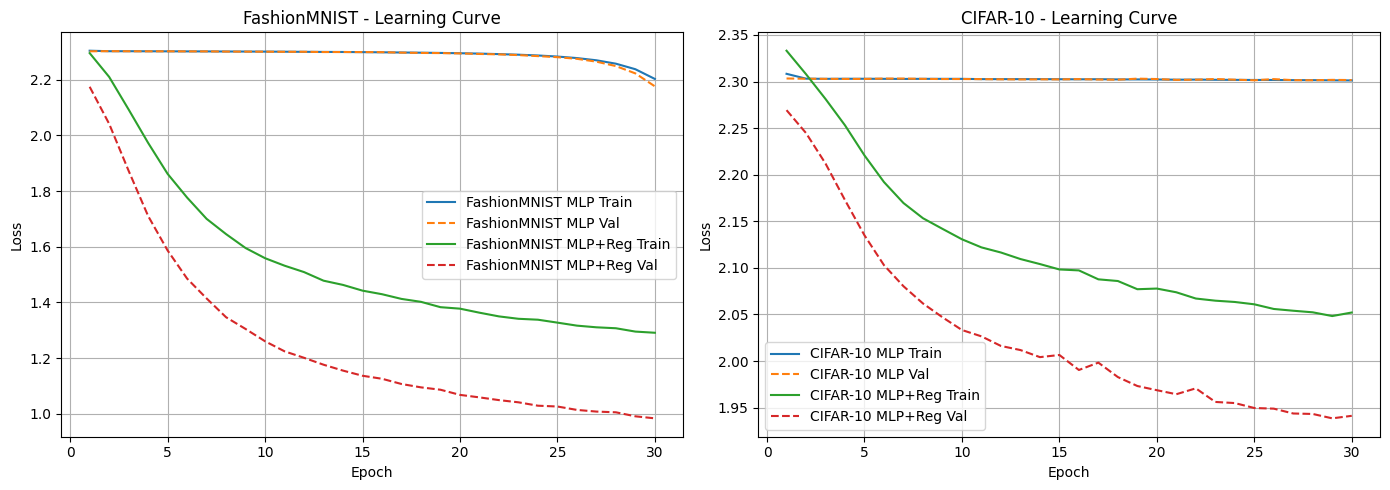

In [ ]:
import matplotlib.pyplot as plt

# 에폭 범위
epochs = list(range(1, 31))

# 실험 결과 데이터 정리
results = {
    "FashionMNIST_MLP": {
        "train_loss": [
            2.3044, 2.3026, 2.3026, 2.3024, 2.3022, 2.3020, 2.3019, 2.3016, 2.3014, 2.3012,
            2.3009, 2.3004, 2.3001, 2.2998, 2.2993, 2.2987, 2.2980, 2.2973, 2.2964, 2.2954,
            2.2940, 2.2922, 2.2901, 2.2873, 2.2834, 2.2780, 2.2700, 2.2578, 2.2379, 2.2030
        ],
        "val_loss": [
            2.3023, 2.3028, 2.3024, 2.3022, 2.3023, 2.3020, 2.3020, 2.3013, 2.3011, 2.3009,
            2.3005, 2.3006, 2.2996, 2.2997, 2.2995, 2.2992, 2.2975, 2.2964, 2.2959, 2.2947,
            2.2927, 2.2913, 2.2887, 2.2850, 2.2812, 2.2753, 2.2651, 2.2492, 2.2229, 2.1764
        ]
    },
    "FashionMNIST_MLP_Reg": {
        "train_loss": [
            2.2958, 2.2103, 2.0931, 1.9732, 1.8619, 1.7767, 1.7003, 1.6454, 1.5954, 1.5589,
            1.5320, 1.5090, 1.4781, 1.4629, 1.4423, 1.4295, 1.4126, 1.4021, 1.3829, 1.3776,
            1.3631, 1.3498, 1.3412, 1.3379, 1.3274, 1.3166, 1.3106, 1.3072, 1.2952, 1.2910
        ],
        "val_loss": [
            2.1748, 2.0417, 1.8728, 1.7105, 1.5866, 1.4856, 1.4143, 1.3467, 1.3046, 1.2604,
            1.2243, 1.2010, 1.1762, 1.1550, 1.1365, 1.1257, 1.1069, 1.0948, 1.0863, 1.0678,
            1.0588, 1.0490, 1.0411, 1.0289, 1.0260, 1.0138, 1.0078, 1.0052, 0.9908, 0.9835
        ]
    },
    "CIFAR10_MLP": {
        "train_loss": [
            2.3083, 2.3031, 2.3029, 2.3030, 2.3030, 2.3029, 2.3028, 2.3029, 2.3029, 2.3029,
            2.3026, 2.3026, 2.3026, 2.3026, 2.3025, 2.3024, 2.3025, 2.3023, 2.3023, 2.3022,
            2.3020, 2.3021, 2.3019, 2.3018, 2.3017, 2.3017, 2.3015, 2.3015, 2.3013, 2.3012
        ],
        "val_loss": [
            2.3033, 2.3030, 2.3029, 2.3028, 2.3028, 2.3032, 2.3032, 2.3029, 2.3027, 2.3027,
            2.3026, 2.3024, 2.3023, 2.3024, 2.3023, 2.3026, 2.3022, 2.3020, 2.3031, 2.3027,
            2.3018, 2.3020, 2.3027, 2.3020, 2.3014, 2.3026, 2.3015, 2.3014, 2.3018, 2.3016
        ]
    },
    "CIFAR10_MLP_Reg": {
        "train_loss": [
            2.3331, 2.3079, 2.2813, 2.2530, 2.2207, 2.1921, 2.1696, 2.1533, 2.1419, 2.1307,
            2.1220, 2.1165, 2.1095, 2.1041, 2.0983, 2.0973, 2.0877, 2.0859, 2.0771, 2.0778,
            2.0738, 2.0671, 2.0648, 2.0634, 2.0609, 2.0559, 2.0540, 2.0523, 2.0483, 2.0521
        ],
        "val_loss": [
            2.2693, 2.2447, 2.2120, 2.1727, 2.1349, 2.1029, 2.0803, 2.0618, 2.0470, 2.0333,
            2.0265, 2.0162, 2.0118, 2.0042, 2.0065, 1.9904, 1.9983, 1.9828, 1.9732, 1.9687,
            1.9644, 1.9707, 1.9561, 1.9549, 1.9496, 1.9489, 1.9437, 1.9432, 1.9385, 1.9412
        ]
    }
}

# 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# FashionMNIST loss curve
ax1.plot(epochs, results["FashionMNIST_MLP"]["train_loss"], label="FashionMNIST MLP Train")
ax1.plot(epochs, results["FashionMNIST_MLP"]["val_loss"], linestyle='--', label="FashionMNIST MLP Val")
ax1.plot(epochs, results["FashionMNIST_MLP_Reg"]["train_loss"], label="FashionMNIST MLP+Reg Train")
ax1.plot(epochs, results["FashionMNIST_MLP_Reg"]["val_loss"], linestyle='--', label="FashionMNIST MLP+Reg Val")
ax1.set_title("FashionMNIST - Learning Curve")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# CIFAR-10 loss curve
ax2.plot(epochs, results["CIFAR10_MLP"]["train_loss"], label="CIFAR-10 MLP Train")
ax2.plot(epochs, results["CIFAR10_MLP"]["val_loss"], linestyle='--', label="CIFAR-10 MLP Val")
ax2.plot(epochs, results["CIFAR10_MLP_Reg"]["train_loss"], label="CIFAR-10 MLP+Reg Train")
ax2.plot(epochs, results["CIFAR10_MLP_Reg"]["val_loss"], linestyle='--', label="CIFAR-10 MLP+Reg Val")
ax2.set_title("CIFAR-10 - Learning Curve")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 문제 4: 자신만의 MLP 모델 구현

자유롭게 MLP 모델을 구현하고, CIFAR-10에 대해서 Accurcy 60% 이상의 성능을 달성하시오.


<br>

---
<br>

고려 가능한 조건들 (수업시간에 다룬 내용?)

- 모델 구조 : Layer 수, dimension 사이즈, Activation function
- 정규화 기법 : Batch norm, dropout, L1,L2 Regularization
- 학습 관련 하이퍼파라미터 : Learning rate, Batch 크기, Epochs, Loss function, Optimizer 등등
- 데이터 증강 기법 : Data Augmentation (data loader 변경 가능합니다.)

<br>



<br>

---
<br>

## 보고서 작성 내용

- 최종 선택한 하이퍼파라미터 세팅과 함께 accuracy, f1 score, precision, recall을 기록하시오.
- 성능 향상을 위해 시도했던 방법들에 대해서 서술하고, 가장 효과적이였던 기법에 대해서 서술하시오.

In [ ]:
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)

from torch.utils.data import random_split
valid_ratio = 0.1
batch_size = 64
n_total = len(train_dataset)
n_valid = int(n_total * valid_ratio)
n_train = n_total - n_valid
train_dataset, valid_dataset = random_split(train_dataset, [n_train, n_valid])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomMLP(nn.Module):
    def __init__(self, input_dim=3*32*32, dropout=0.3, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)

        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(256)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(64)

        self.dropout = nn.Dropout(p=dropout)

        self.fc_last = nn.Linear(64, num_classes)
        self.auxil = nn.Linear(512, num_classes)  # fc2 출력 사용

    def forward(self, x):
        x = torch.flatten(x, 1)

        x1 = F.gelu(self.bn1(self.fc1(x)))
        x2 = F.gelu(self.bn2(self.fc2(x1)))
        aux_out = self.auxil(x2)  # 보조 출력

        x3 = F.gelu(self.bn3(self.fc3(x2)))
        x4 = F.gelu(self.bn4(self.fc4(x3)))
        x5 = F.gelu(self.bn5(self.fc5(x4)))
        x5 = self.dropout(x5)

        out = self.fc_last(x5)
        return out, aux_out

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_epoch(model, dataloader, optimizer, device, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs, aux_outputs = model(images)

        main_loss = criterion(outputs, labels)
        aux_loss = criterion(aux_outputs, labels)
        loss = main_loss + 0.3 * aux_loss  # aux output에 가중치 적용

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    return train_loss, train_acc


def evaluate(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    eval_loss = running_loss / total
    accuracy = correct / total
    return eval_loss, accuracy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomMLP(input_dim=3072, num_classes=10).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss()
num_epochs = 50
best_val_acc = 0.0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

print(f"CIFAR-10, MLPnet Model Train ...")

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, criterion)

    # 평가
    val_loss, val_acc = evaluate(model, valid_loader, device)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "custom_mlp_best.pth")

    print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

# 최종 Test 평가
val_loss, test_acc = evaluate(model, test_loader, device)
print(f"Test Loss {val_loss:.4f}, Test Acc {test_acc:.4f}")

CIFAR-10, MLPnet Model Train ...
Epoch 1: Train Loss 2.4678, Train Acc 0.3230 | Val Loss 1.7450, Val Acc 0.3768
Epoch 2: Train Loss 2.2016, Train Acc 0.3946 | Val Loss 1.6783, Val Acc 0.3956
Epoch 3: Train Loss 2.1066, Train Acc 0.4221 | Val Loss 1.5882, Val Acc 0.4216
Epoch 4: Train Loss 2.0397, Train Acc 0.4412 | Val Loss 1.5490, Val Acc 0.4338
Epoch 5: Train Loss 1.9917, Train Acc 0.4554 | Val Loss 1.6015, Val Acc 0.4198
Epoch 6: Train Loss 1.9511, Train Acc 0.4662 | Val Loss 1.5929, Val Acc 0.4288
Epoch 7: Train Loss 1.9284, Train Acc 0.4703 | Val Loss 1.4683, Val Acc 0.4646
Epoch 8: Train Loss 1.8912, Train Acc 0.4804 | Val Loss 1.4686, Val Acc 0.4678
Epoch 9: Train Loss 1.8758, Train Acc 0.4888 | Val Loss 1.5201, Val Acc 0.4602
Epoch 10: Train Loss 1.8508, Train Acc 0.4935 | Val Loss 1.9848, Val Acc 0.3668
Epoch 11: Train Loss 1.8063, Train Acc 0.5072 | Val Loss 1.3851, Val Acc 0.4986
Epoch 12: Train Loss 1.7799, Train Acc 0.5158 | Val Loss 1.3317, Val Acc 0.5254
Epoch 13: Train 

In [ ]:
# 1. 동일한 구조의 모델 인스턴스 다시 생성
loaded_model = CustomMLP(input_dim=3072, num_classes=10).to(device)

# 2. 저장된 파라미터 로드
loaded_model.load_state_dict(torch.load("custom_mlp_best.pth"))
loaded_model.eval()  # 평가 모드 전환

# 3. 성능 측정
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 예측값과 실제값 수집
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs, _ = loaded_model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 4. 평가 지표 계산
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  # 또는 'weighted'
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# 5. 출력
print(f" 최종 Test 결과")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

 최종 Test 결과
Accuracy : 0.6014
Precision: 0.5977
Recall   : 0.6014
F1 Score : 0.5978


# Extra Credit: MLP 모델을 이용한 STL-10 이미지 분류


STL-10 데이터셋에 대해 MLP만을 사용한 이미지 분류 모델을 구현합니다.

추가적인 기법들이나 방법론 적용 가능 (출처가 있다면 첨부)


<br>

---
<br>

## 제한 사항

- CNN, Transformer Layer 사용 금지 (예: `nn.Conv2d` 사용 불가, `nn.Linear`만 사용)
- Custrom으로 CNN이나 Transformer Layer를 만드는 것도 안됩니다.
- Pretrained 모델 파라미터 사용 금지

<br>

---
<br>

## 보너스 점수 조건



- Accuracy > 55% : +5점
- Accuracy > 60% : +5점

<br>

---
<br>


## 보고서 작성 내용

- 최종 선택한 하이퍼파라미터 세팅과 함께 accuracy, f1 score, precision, recall을 기록하시오.
- 성능 향상을 위해 시도했던 방법들에 대해서 서술하고, 가장 효과적이였던 기법에 대해서 서술하시오.


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(96),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3))
])

transform_test = transforms.Compose([
    transforms.Resize(96),
    transforms.CenterCrop(96),
    transforms.ToTensor(),
])

from torchvision.datasets import STL10
from torch.utils.data import DataLoader

train_dataset = STL10(root='./data', split='train', download=True, transform=transform_train)
test_dataset = STL10(root='./data', split='test', download=True, transform=transform_test)

from torch.utils.data import random_split
valid_ratio = 0.1
batch_size = 64
n_total = len(train_dataset)
n_valid = int(n_total * valid_ratio)
n_train = n_total - n_valid
train_dataset, valid_dataset = random_split(train_dataset, [n_train, n_valid])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class STL10_CustomMLP(nn.Module):
    def __init__(self, input_dim=3*96*96, num_classes=10, dropout=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 4096)
        self.bn1 = nn.BatchNorm1d(4096)

        self.fc2 = nn.Linear(4096, 2048)
        self.bn2 = nn.BatchNorm1d(2048)
        self.auxil = nn.Linear(2048, num_classes)

        self.fc3 = nn.Linear(2048, 1024)
        self.bn3 = nn.BatchNorm1d(1024)

        self.fc4 = nn.Linear(1024, 512)
        self.bn4 = nn.BatchNorm1d(512)

        self.fc5 = nn.Linear(512, 256)
        self.bn5 = nn.BatchNorm1d(256)

        self.dropout = nn.Dropout(p=dropout)
        self.fc_last = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)

        x1 = F.relu(self.bn1(self.fc1(x)))
        x2 = F.relu(self.bn2(self.fc2(x1)))
        aux_out = self.auxil(x2)

        x3 = F.relu(self.bn3(self.fc3(x2)))
        x4 = F.relu(self.bn4(self.fc4(x3)))
        x5 = F.relu(self.bn5(self.fc5(x4)))
        x5 = self.dropout(x5)

        out = self.fc_last(x5)
        return out, aux_out

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_epoch(model, dataloader, optimizer, device, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs, aux_outputs = model(images)

        main_loss = criterion(outputs, labels)
        aux_loss = criterion(aux_outputs, labels)
        loss = main_loss + 0.3 * aux_loss  # aux output에 가중치 적용

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    return train_loss, train_acc


def evaluate(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    eval_loss = running_loss / total
    accuracy = correct / total
    return eval_loss, accuracy

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = STL10_CustomMLP(input_dim=3*96*96, num_classes=10).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.04)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss()
num_epochs = 50
best_val_acc = 0.0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

print(f"STL10, MLP Custom Model Train ...")

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, criterion)

    # 평가
    val_loss, val_acc = evaluate(model, valid_loader, device)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "STL10_model.pth")

    print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

# 최종 Test 평가
val_loss, test_acc = evaluate(model, test_loader, device)
print(f"Test Loss {val_loss:.4f}, Test Acc {test_acc:.4f}")

STL10, MLP Custom Model Train ...
Epoch 1: Train Loss 2.7611, Train Acc 0.2120 | Val Loss 2.0233, Val Acc 0.2700
Epoch 2: Train Loss 2.6206, Train Acc 0.2504 | Val Loss 1.9534, Val Acc 0.2900
Epoch 3: Train Loss 2.5553, Train Acc 0.2640 | Val Loss 2.0891, Val Acc 0.2340
Epoch 4: Train Loss 2.5134, Train Acc 0.2760 | Val Loss 1.9243, Val Acc 0.2980
Epoch 5: Train Loss 2.4841, Train Acc 0.2907 | Val Loss 1.9333, Val Acc 0.2640
Epoch 6: Train Loss 2.4900, Train Acc 0.2838 | Val Loss 1.9633, Val Acc 0.2400
Epoch 7: Train Loss 2.4431, Train Acc 0.2909 | Val Loss 1.8922, Val Acc 0.2880
Epoch 8: Train Loss 2.4202, Train Acc 0.3073 | Val Loss 1.8741, Val Acc 0.3080
Epoch 9: Train Loss 2.4232, Train Acc 0.3111 | Val Loss 1.9511, Val Acc 0.2700
Epoch 10: Train Loss 2.4180, Train Acc 0.3011 | Val Loss 1.9252, Val Acc 0.3100
Epoch 11: Train Loss 2.3451, Train Acc 0.3280 | Val Loss 1.8970, Val Acc 0.2940
Epoch 12: Train Loss 2.3287, Train Acc 0.3282 | Val Loss 1.7927, Val Acc 0.3420
Epoch 13: Train